In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch
from torch import nn

torch.__version__

'1.13.1'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 01 PyTorch Workflow


1. Data (prepare and load)
2. Build Model
3. Fitting the model to data (training)
4. Making predictions and evaluting a model (inference)
5. Saving and loading a model
6. Putting it all together

We'll be using a linear regression model fomula to make a straight line.

A parameter is what the model will learn, e.g. the correct weights etc etc 

### Preparing and Loading Data

In [3]:
#Parameters
weight = 0.7 
bias = 0.3 

# Creating dataset
start = 0
end = 1 
step = 0.02 

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

In [5]:
y.shape

torch.Size([50, 1])

### Splitting data into training and test sets

In [6]:
train_split = int( 0.8 * len(X) )

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(40, 10)

In [7]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compare predictions
    """
    plt.figure(figsize=(10, 7))

    #Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    #Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

    plt.legend(prop={"size": 14})
    plt.show()

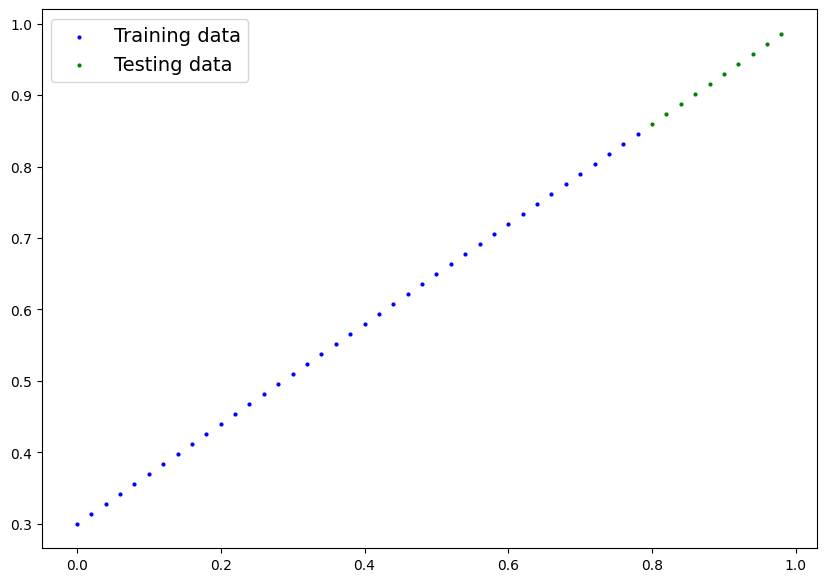

In [8]:
plot_predictions()

### Build a model

In [9]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(1)
            )
        
        self.bias = nn.Parameter(
            torch.randn(1)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

In [10]:
torch.manual_seed(1)
torch.randn(1)

tensor([0.6614])

In [11]:
# Creating a random seed
torch.manual_seed(42)

#Create instance of the model
model_0 = LinearRegressionModel().to(device)

model_0

LinearRegressionModel()

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

In [13]:
#Shows the name
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367], device='cuda:0')),
             ('bias', tensor([0.1288], device='cuda:0'))])

In [14]:
# aim to get the value of 
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

In [15]:
# Make predictions with model

#Disables the gradient calculation
with torch.inference_mode():
    y_preds = model_0(X_test.to(device)).cpu()

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

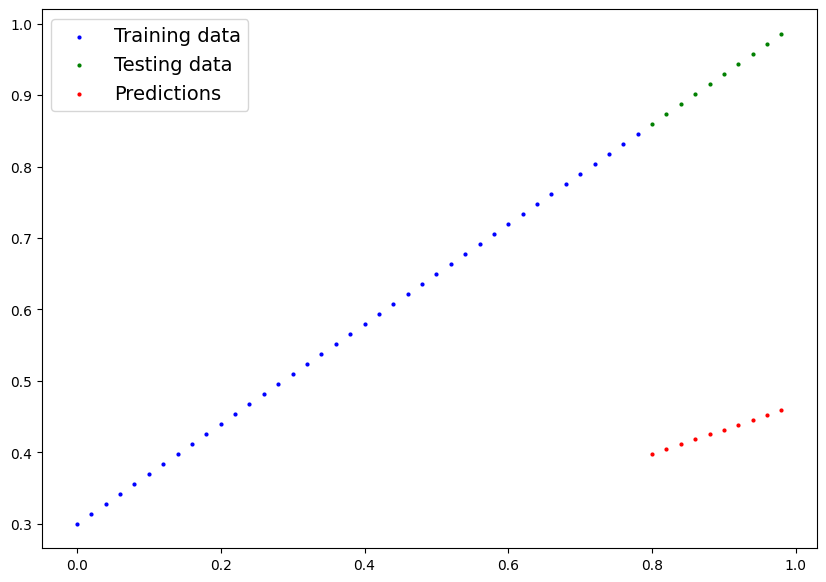

In [16]:
plot_predictions(predictions=y_preds)

### Train model

Need to measure how poorly the model is running that is why you need to use a loss/cost/citerion function.

Things we need to train

* **Loss Function:** Measures how wrong your model's predictions are to the ideal outputs, lower is better

* **Optimizer:** Takes into account the loss of a model and adjust the model's parameters (e.g. weight, bias) to improve the loss function.

Takes in the .parameters() as input.

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss() # Same as MAE

# Setup a optimizer (adjust the parameters to reduce the loss)
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.001)

### Building a training & testing loop in PyTorch

Steps:

0. Loop through the data
1. Forward pass (involves data moving through our model's `forward()`) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each parameters in respect to the loss
5. Optimizer step - use the optimizer to adjust the model's parameters to try to improve the loss.


In [18]:
# An epoch is one loop through the data...
epochs = 2000

epoch_count = []
train_loss_values = []
test_loss_values = []

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # Sets all parameters that require gradients to require gradients

    #1. Forward pass
    y_pred = model_0(X_train)

    #2. Calculate Loss
    loss = loss_fn(y_pred, y_train)

    #3. optimizer zero grad -> resets the gradient calculation
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will acculmate through the loop so... we have to 0 them from above.

    ## Testing
    model_0.eval() # used to disable training mode such as in dropout etc etc
    with torch.inference_mode(): # turns off gradient tracking and other things
        # 1. Do forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss 
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.cpu().item())
        test_loss_values.append(test_loss.cpu().item())
        
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict(),end='\r')

Epoch: 0 | Train loss: 0.31288135051727295 | Test loss: 0.4931890666484833
Epoch: 10 | Train loss: 0.3013603687286377 | Test loss: 0.4797181189060211r([0.1298], device='cuda:0'))])
Epoch: 20 | Train loss: 0.28983935713768005 | Test loss: 0.4662471413612366([0.1398], device='cuda:0'))])
Epoch: 30 | Train loss: 0.2783183753490448 | Test loss: 0.4527761936187744r([0.1498], device='cuda:0'))])
Epoch: 40 | Train loss: 0.26679736375808716 | Test loss: 0.43930521607398987[0.1598], device='cuda:0'))])
Epoch: 50 | Train loss: 0.2552764117717743 | Test loss: 0.4258342683315277r([0.1698], device='cuda:0'))])
Epoch: 60 | Train loss: 0.24375538527965546 | Test loss: 0.41236335039138794[0.1798], device='cuda:0'))])
Epoch: 70 | Train loss: 0.2322344034910202 | Test loss: 0.3988923728466034r([0.1898], device='cuda:0'))])
Epoch: 80 | Train loss: 0.22071340680122375 | Test loss: 0.38542142510414124[0.1998], device='cuda:0'))])
Epoch: 90 | Train loss: 0.2091924250125885 | Test loss: 0.3719504475593567r([

In [19]:
# Actual parameters, very close to the learned weights from model
weight, bias

(0.7, 0.3)

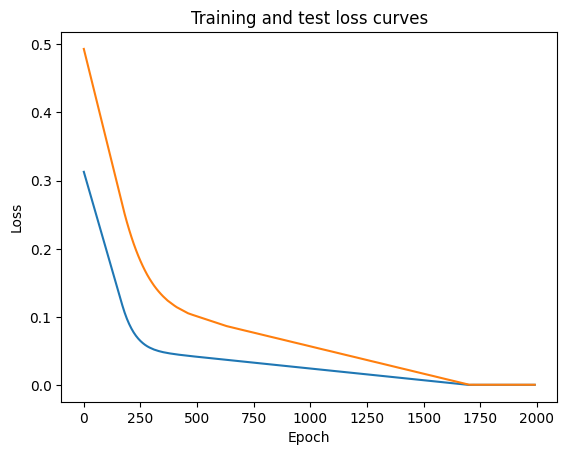

In [20]:
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [21]:
#Predicting test
with torch.inference_mode():
    y_preds_new = model_0(X_test.to(device)).cpu()

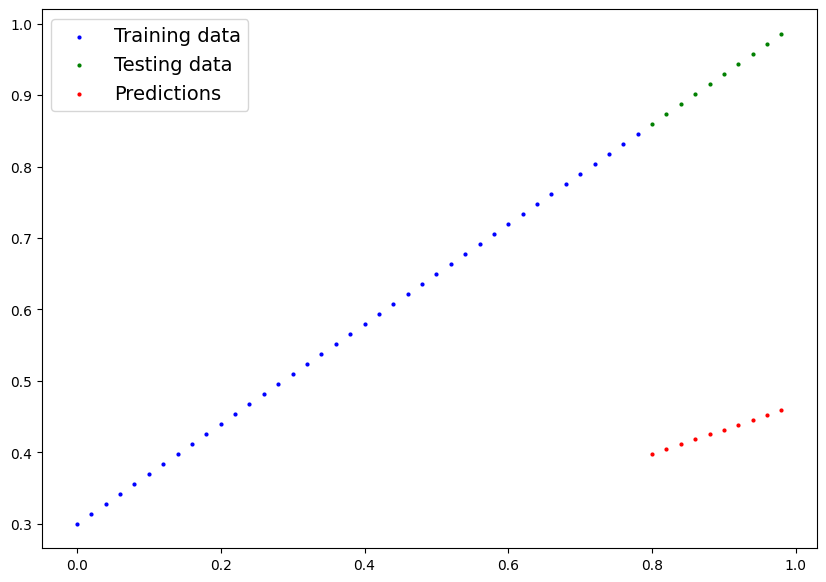

In [22]:
plot_predictions(predictions=y_preds.numpy())

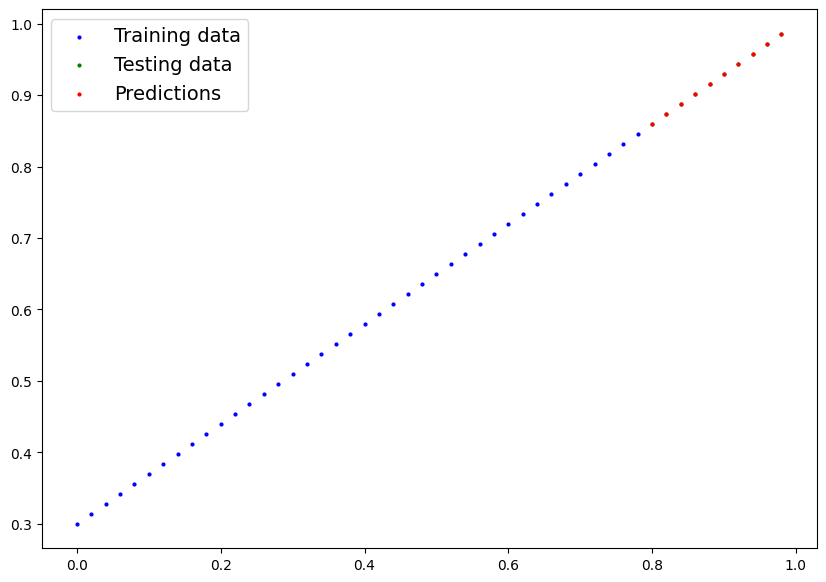

In [23]:
plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch

3 Main methodds to save and load models in PyTorch

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [24]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6994], device='cuda:0')),
             ('bias', tensor([0.2998], device='cuda:0'))])

In [25]:
#Saving 
from pathlib import Path

#1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_0.pth


### Loading a Model using state_dict

In [26]:
loaded_model_0 = LinearRegressionModel().to(device)

#Load the saved state_dict of model_0 
loaded_model_0.load_state_dict(
    torch.load(f=MODEL_SAVE_PATH)
    )

loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6994], device='cuda:0')),
             ('bias', tensor([0.2998], device='cuda:0'))])

In [27]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8593],
        [0.8733],
        [0.8873],
        [0.9013],
        [0.9152],
        [0.9292],
        [0.9432],
        [0.9572],
        [0.9712],
        [0.9852]], device='cuda:0')

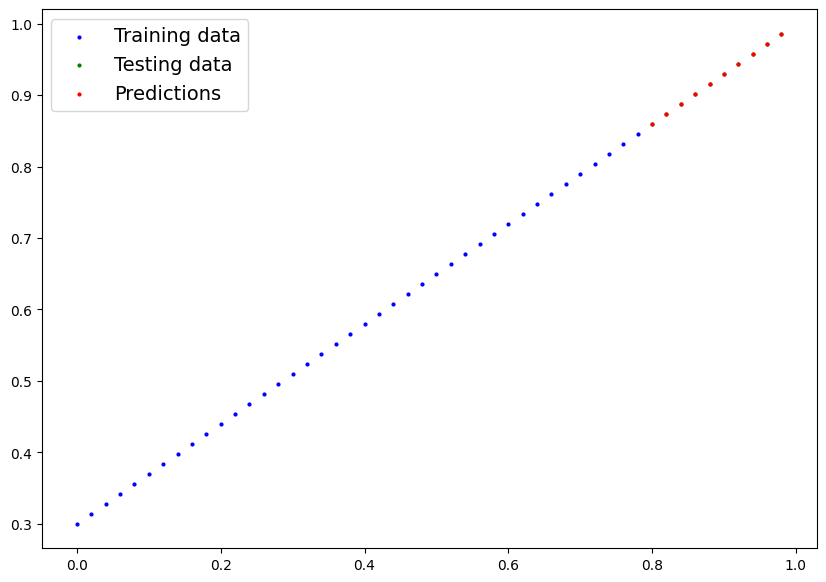

In [28]:
plot_predictions(predictions=loaded_model_preds.cpu().numpy())